# Music Recommendation Model
## Introduction
- We are going to create a music recommendation model based on tracks from Spotify! We will take a given track and gives the user some other who are close in sound to it. We will use a KNN model based on audio features to get this desired outcome, finding the track in the model and outputting the closest tracks which meet our conditions. 

## Data
- The data we are using for this model is a dataset of Spotify tracks ranging over 125 different genres which include many different audio features of each track such as danceability, energy, tempo, etc. It was gathered together by Maharshipandya on kaggle and was last updated 2 years ago, so it may not include newer tracks that were released after 2023. A link to his kaggle account will be linked in the README, if you wish to look more of his datasets!

## Audio Feature Model
- Let's first start with the song feature model using the spotify_dataset.csv in the repository. We must do some data cleaning first then we can use our dataset to create a model

In [ ]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Read and examine the data set
data = pd.read_csv("spotify_dataset.csv")
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [19]:
# Further analyze category information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [20]:
# It looks like we have some null values in track_id, artists, album_name, and track_name so lets delete them
data.dropna(inplace=True)

# Then lets examine our columns now with these changes
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        113999 non-null  int64  
 1   track_id          113999 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        113999 non-null  int64  
 6   duration_ms       113999 non-null  int64  
 7   explicit          113999 non-null  bool   
 8   danceability      113999 non-null  float64
 9   energy            113999 non-null  float64
 10  key               113999 non-null  int64  
 11  loudness          113999 non-null  float64
 12  mode              113999 non-null  int64  
 13  speechiness       113999 non-null  float64
 14  acousticness      113999 non-null  float64
 15  instrumentalness  113999 non-null  float64
 16  liveness          113999 

In [21]:
# We also have to look out for duplicate rows in this dataset and eliminate them so that we do not get the same song twice in reccomendations
duplicate_rows = data['track_id'].duplicated().sum()
if duplicate_rows != 0:
    data = data.drop_duplicates(subset=['track_id'])

# Return duplicate rows to see how much we have deleted
duplicate_rows

24259

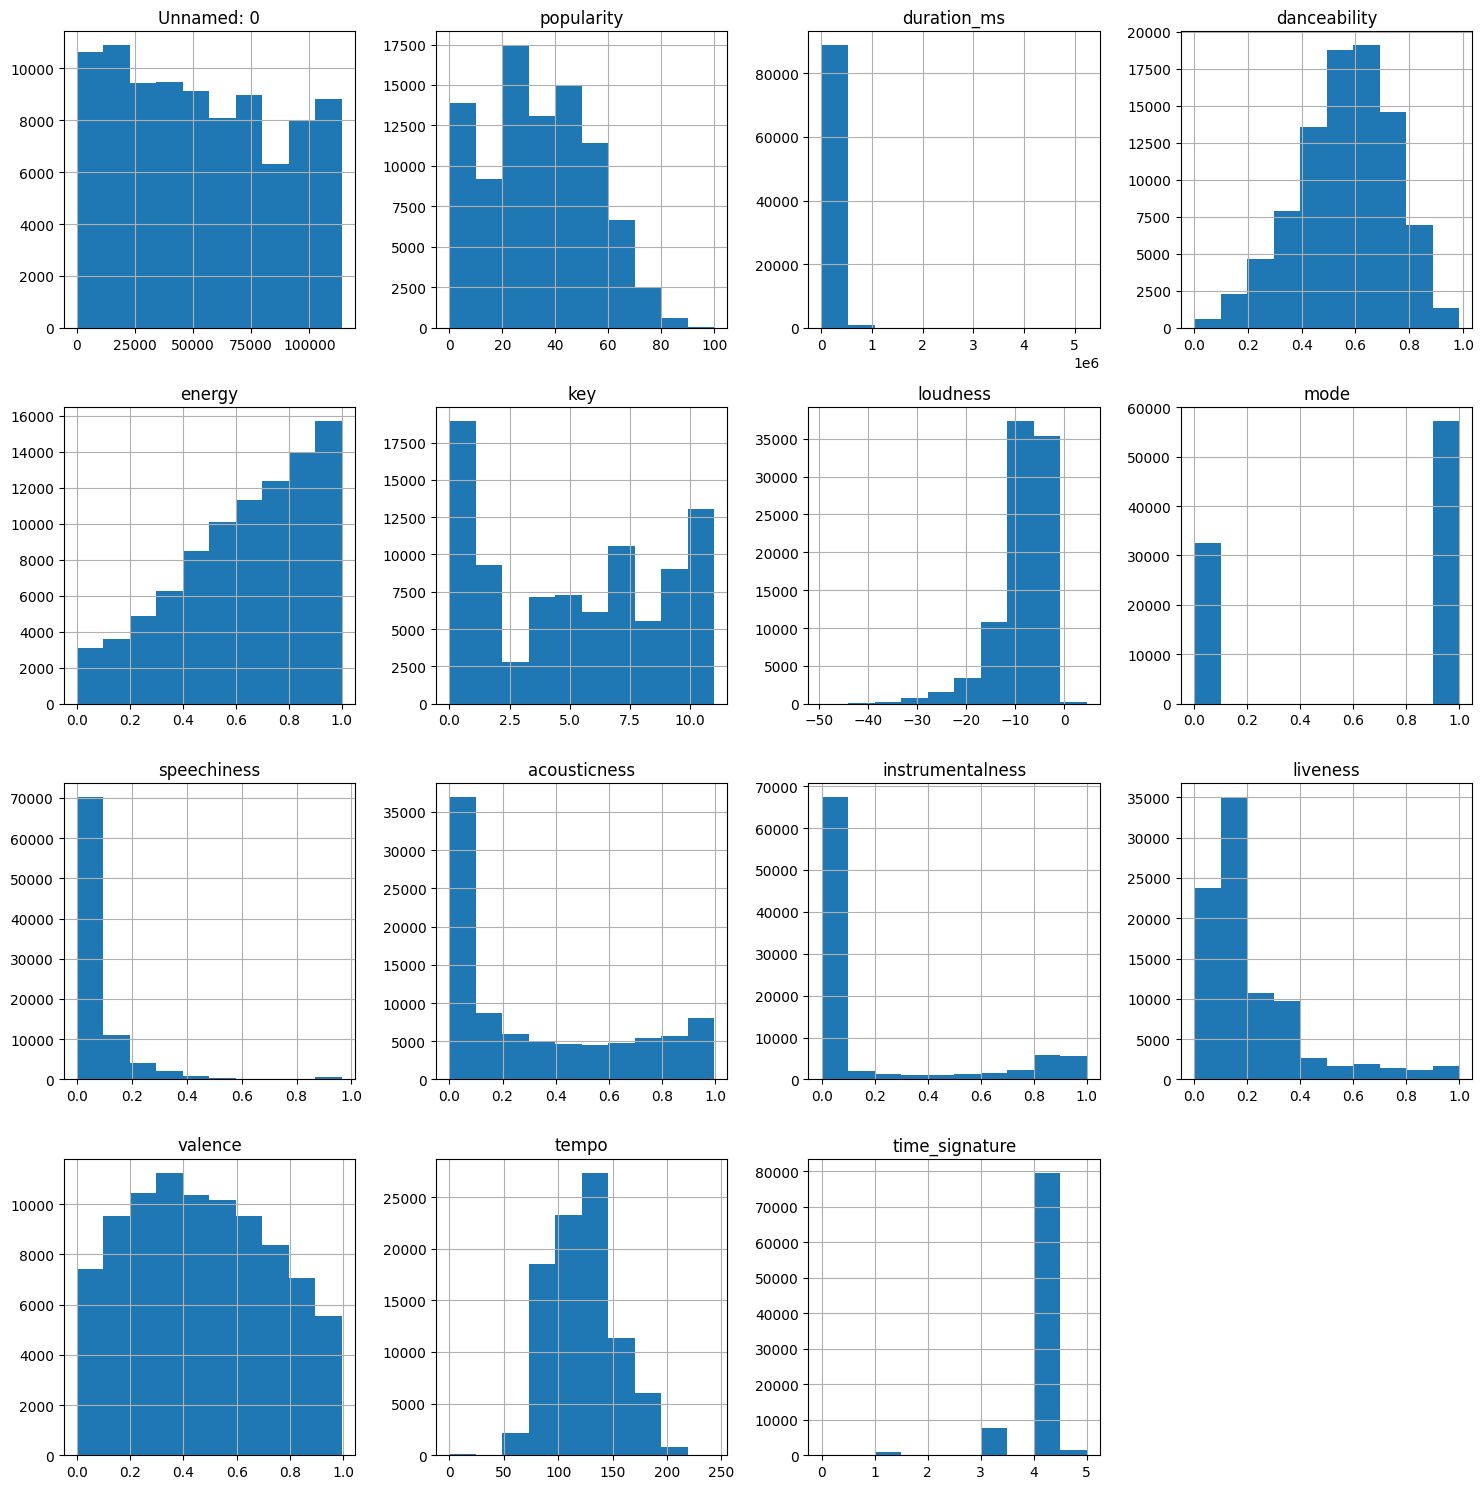

In [ ]:
# Lets visualize our data a little better so we know what we are working with before working with it
# We can ignore unnamed: 0 since that is the index and does not give us and valuable information
data.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

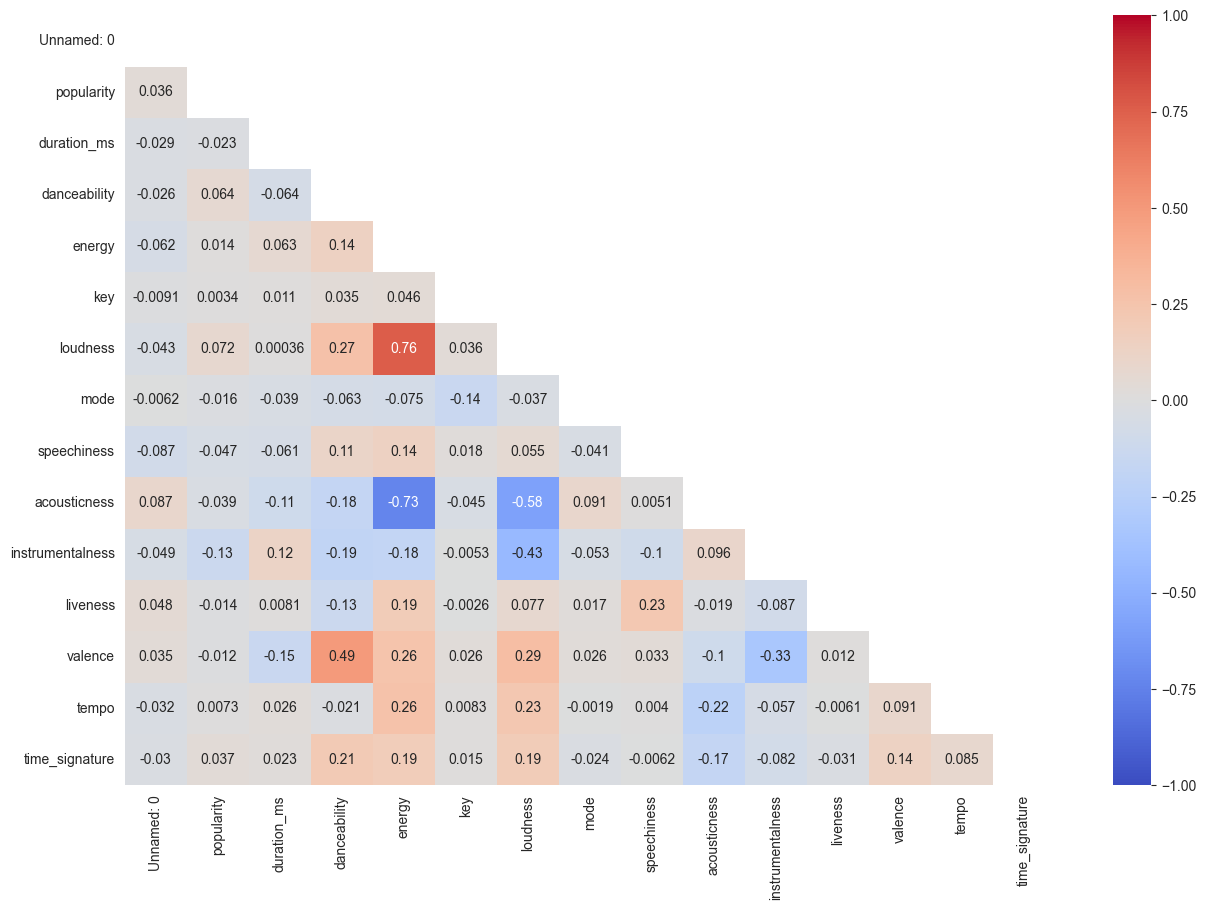

In [25]:
# Use a heat map to see which features correlate the most with eachother
import seaborn as sb
num_data = data[data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64')]]
corr = num_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.set_style('white')
plt.figure(figsize=(15, 10))
sb.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Select relevant audio features to input into our Nearest Neighbors model
# Use data visualizations to help choose which features are considered "relevant"
feature_columns = ["danceability", "energy", "loudness", "speechiness", "acousticness",
                   "instrumentalness", "liveness", "valence", "tempo"]

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[feature_columns])

# Fit a nearest neighbors model using our scaled features
nn_model = NearestNeighbors(n_neighbors=6, metric="cosine") # 6 neighbors for 5 recommendations and our chosen song
nn_model.fit(scaled_features)

# Create a function to recommend songs based on a given track
def recommend_songs_knn(track_name, top_n=5):
    if track_name not in data["track_name"].values:
        return f"Track '{track_name}' not found in dataset"
    
    # Extract index of the track
    track_index = data[data["track_name"] == track_name].index[0]

    # Get nearest neighbors
    distances, indices = nn_model.kneighbors([scaled_features[track_index]], n_neighbors=top_n * 2)

    # Retrieve recommended track names and artists, avoiding duplicates
    seen_tracks = set()
    recommendations = []

    for idx in indices[0][1:]:  # Skip the first since it's the song itself
        track = data.iloc[idx][["track_name", "artists", "track_genre"]]
        track_tuple = (track["track_name"], track["artists"])

        if track_tuple not in seen_tracks:
            seen_tracks.add(track_tuple)
            recommendations.append(track)

        if len(recommendations) >= top_n:
            break

    return pd.DataFrame(recommendations)

# Example output
recommend_songs_knn("Lithium")

,track_name,artists,track_genre
30921,Used To Love (with Dean Lewis),Martin Garrix;Dean Lewis,edm
97668,Se For Arrumar Alguém,Murilo Huff,sertanejo
70053,髮如雪,Jay Chou,mandopop
100238,Game Lover,Los Caligaris,ska
9318,O Processo,Suellen Brum,brazil


- These recommendations aren't too bad based on audio features, but the genres are all over the place. Some people might want to find similar songs within a certain genre, so lets create a function which can filter by a genre.

In [27]:
def filtered_recommend_songs(track_name, genre=None, top_n=5):
    if track_name not in data["track_name"].values:
        return f"Track '{track_name}' not found in dataset"
    
    # Extract index of the track
    track_index = data[data["track_name"] == track_name].index[0]

    # Get nearest neighbors
    distances, indices = nn_model.kneighbors([scaled_features[track_index]], n_neighbors=top_n * 1000)

    # Retrieve recommended track names and artists, avoiding duplicates
    seen_tracks = set()
    recommendations = []

    for idx in indices[0][1:]:  # Skip the first since it's the song itself
        track = data.iloc[idx][["track_name", "artists", "track_genre"]]
        track_tuple = (track["track_name"], track["artists"])

        if genre is None or track["track_genre"] == genre:
                seen_tracks.add(track_tuple)
                recommendations.append(track)

        if len(recommendations) >= top_n:
            break

    return pd.DataFrame(recommendations)

filtered_recommend_songs("Lithium", genre="alt-rock")

,track_name,artists,track_genre
2218,Automobile,KALEO,alt-rock
2113,It's Not My Time - Acoustic,3 Doors Down,alt-rock
2705,Where Did You Sleep Last Night,Nirvana,alt-rock
2836,Para No Verme Más - En Vivo,La Vela Puerca,alt-rock
2547,Un Toque Mágico,Tex Tex,alt-rock


- This output is little better and gives recommendations which are closer to the given track in terms of genre, but similar audio features. Now Lets plot the dataset to get a better visualization of the Nearest Neighbors algorithm we are using.

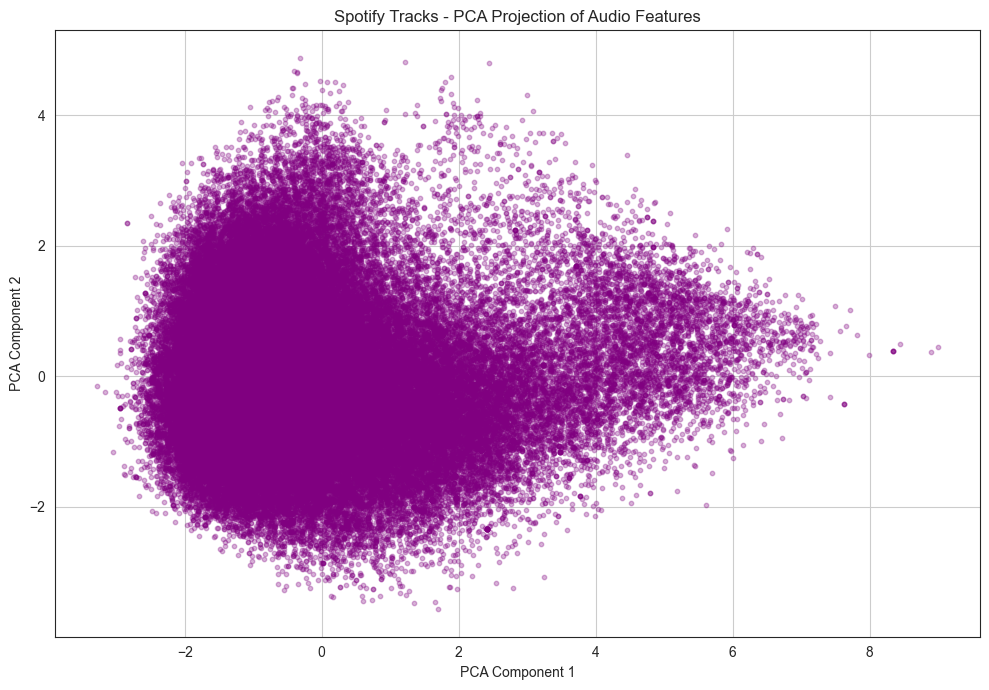

In [28]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the entire dataset in 2D PCA space
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.3, s=10, c='purple')
plt.title("Spotify Tracks - PCA Projection of Audio Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()